<a href="https://colab.research.google.com/github/govardhan-06/DL-models/blob/main/FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.makedirs("root",exist_ok=True)
os.makedirs("root/fer2013",exist_ok=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil
import os

# Source folder path in Google Drive
src_folder = '/content/drive/MyDrive/AIML'

# Destination folder path in Colab
dest_folder = '/content/root/fer2013'

# Create destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Copy the entire folder
shutil.copytree(src_folder, dest_folder, dirs_exist_ok=True)

'/content/root/fer2013'

###1. Data Ingestion phase

In [4]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision.datasets

train_set= torchvision.datasets.FER2013(
    root="root",
    split="train",
    transform=ToTensor(),
    target_transform=None,
)

test_set= torchvision.datasets.FER2013(
    root="root",
    split="test",
    transform=ToTensor(),
    target_transform=None,
)

In [5]:
print(f"Length of train set: {len(train_set)}")
print(f"Length of test set: {len(test_set)}")

Length of train set: 28709
Length of test set: 7178


In [6]:
print(train_set)
print("\n")
print(test_set)

Dataset FER2013
    Number of datapoints: 28709
    Root location: root
    split=train
    StandardTransform
Transform: ToTensor()


Dataset FER2013
    Number of datapoints: 7178
    Root location: root
    split=test
    StandardTransform
Transform: ToTensor()


In [7]:
import pandas as pd
df=pd.read_csv("root/fer2013/train.csv")
##Does not having a labels for different emotions inside the dataset

In [8]:
print("Sample data:")
print(train_set.__getitem__(10))

Sample data:
(tensor([[[0.1176, 0.0941, 0.0824,  ..., 0.1451, 0.1725, 0.1451],
         [0.1216, 0.0863, 0.0824,  ..., 0.1451, 0.1373, 0.1608],
         [0.1059, 0.0863, 0.0745,  ..., 0.1294, 0.1333, 0.1569],
         ...,
         [0.1137, 0.1137, 0.1020,  ..., 0.4627, 0.5176, 0.5804],
         [0.1176, 0.1176, 0.1059,  ..., 0.6039, 0.6235, 0.6510],
         [0.1255, 0.1137, 0.1098,  ..., 0.6745, 0.6784, 0.6784]]]), 0)


In [9]:
##Mapping emotion label to the respective emotion terms
emotion_label_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [10]:
df['Emotions']= df['emotion'].map(emotion_label_map)
df.head()

,emotion,pixels,Emotions
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral


### Checking the input and output

In [11]:
image, label = train_set.__getitem__(0)
print(f"Image shape: {image.shape} -> [colour_channels,height,width]")
print(f"Image label: {label}")

Image shape: torch.Size([1, 48, 48]) -> [colour_channels,height,width]
Image label: 0


### Visualizing the image

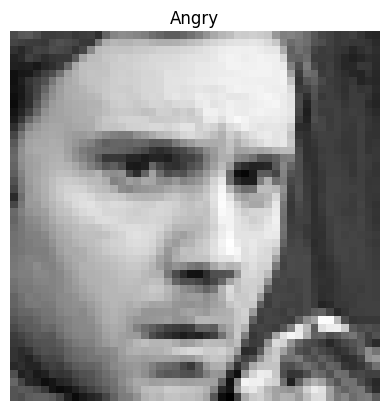

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(emotion_label_map[label])
plt.axis("off")
plt.show()

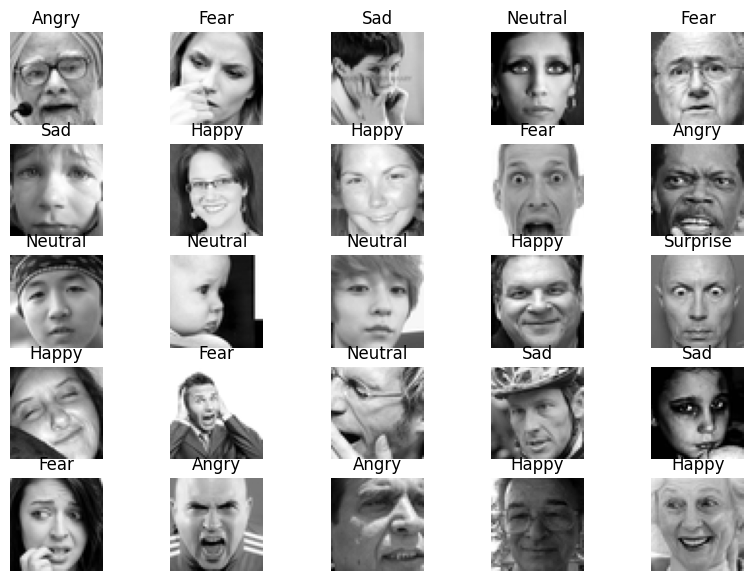

In [13]:
torch.manual_seed(42)
rows,cols=5,5
plt.figure(figsize=(10,7))
for i in range(1,rows*cols+1):
  img,label=train_set[i]
  plt.subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(emotion_label_map[label])
  plt.axis('off')

### Turning image data to batches

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader= DataLoader(train_set,BATCH_SIZE,shuffle=True)
test_dataloader= DataLoader(test_set,BATCH_SIZE,shuffle=True)

In [15]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of batch size : {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of batch size : {BATCH_SIZE}")

Length of train dataloader: 898 batches of batch size : 32
Length of test dataloader: 225 batches of batch size : 32


### Inspection image inside the batch

In [16]:
train_batch_image, train_batch_label=next(iter(train_dataloader))
print(f"Image batch shape: {train_batch_image.shape} -> [batch_size,colour_channels,height,width]")
print(f"Label batch shape: {train_batch_label.shape} -> [batch_size]")

Image batch shape: torch.Size([32, 1, 48, 48]) -> [batch_size,colour_channels,height,width]
Label batch shape: torch.Size([32]) -> [batch_size]


First Batch


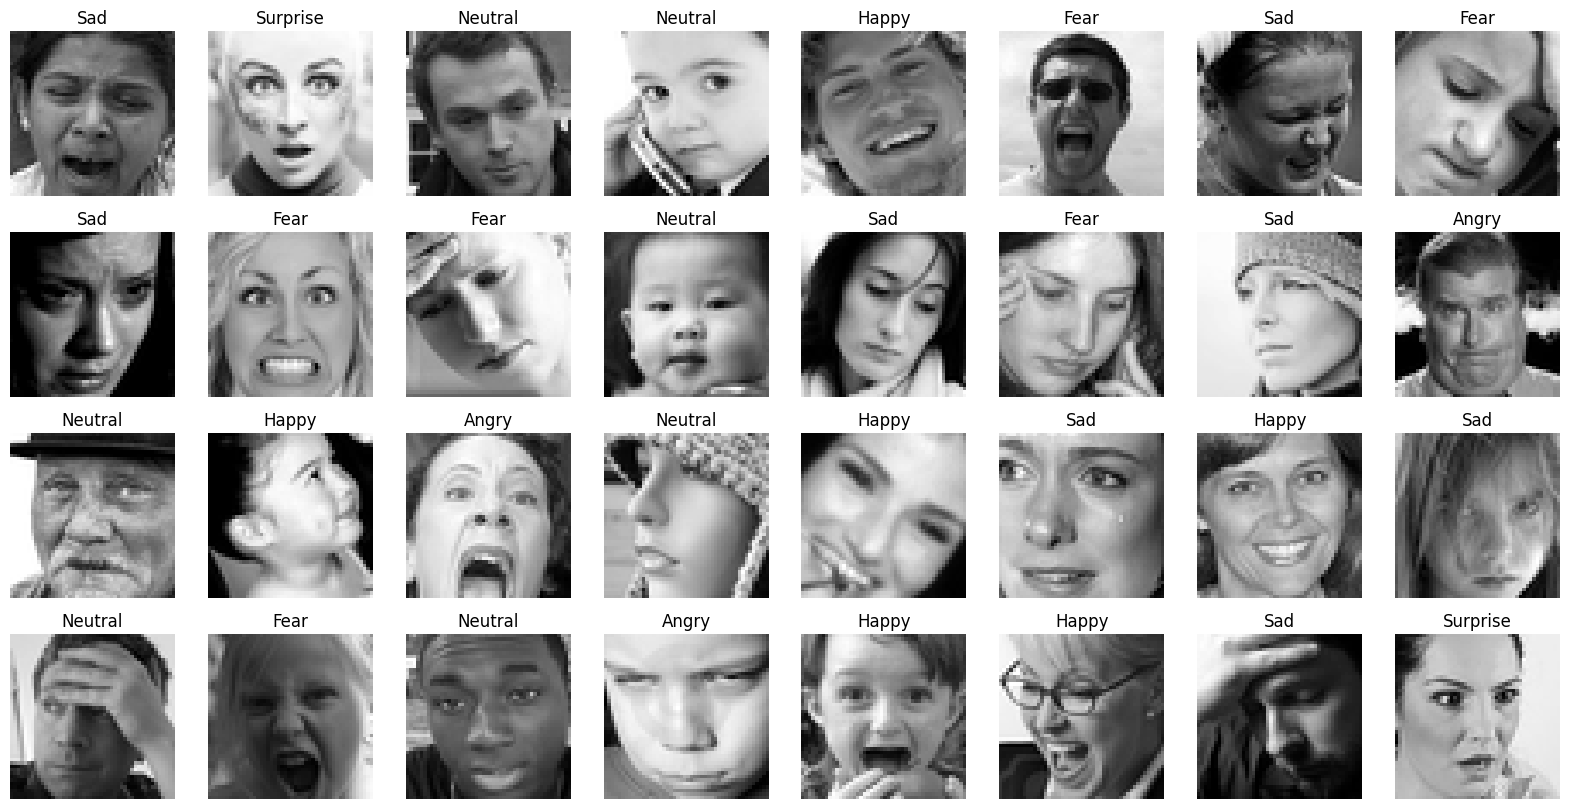

In [17]:
plt.figure(figsize=(20,10))
print("First Batch")
for i in range(0,BATCH_SIZE):
  plt.subplot(4,8,i+1)
  plt.imshow(train_batch_image[i].squeeze(),cmap="gray")
  plt.title(emotion_label_map[train_batch_label[i].item()])
  plt.axis('off')

### Device agnostic code

In [20]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Model Training

In [21]:
import torchvision.models as models
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.6MB/s]


In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary
summary(model,input_size=(32, 3, 224, 224),col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        True
│    │ 

### Transfer Learning

In [24]:
#Freezing the Base layers
for param in model.parameters():
  param.requires_grad=False

In [25]:
# Modify the first convolutional layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                        stride=model.conv1.stride, padding=model.conv1.padding, bias=False)

In [26]:
#Altering the classifier to make it apt for our purpose
torch.manual_seed(42) #CPU
torch.cuda.manual_seed(42) #GPU
model.fc=nn.Linear(in_features=512,out_features=7,bias=True)

In [27]:
summary(model,input_size=(32, 1, 224, 224),col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 1, 224, 224]         [32, 7]                   --                        Partial
├─Conv2d: 1-1                            [32, 1, 224, 224]         [32, 64, 112, 112]        3,136                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 64, 56, 56]          --                        False
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          [32, 64, 56, 56]          --                        False
│

### Training

In [28]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [29]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
import tqdm as tqdm
from typing import Tuple

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device) -> Tuple[float,float]:
      '''
      Performs a training with model trying to learn on dataloader.
      Returns train loss and train accuracy.
      '''
      model.train()
      train_loss,train_acc=0,0
      for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        train_loss+=loss.item()
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      train_loss/=len(dataloader)
      train_acc/=len(dataloader)
      return train_loss,train_acc

def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device) -> Tuple[float,float]:
      '''
      Performs a testing with model on dataloader.
      Returns test loss and test accuracy.
      '''
      model.eval()
      test_loss,test_acc=0,0
      with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
          X,y=X.to(device),y.to(device)
          y_pred=model(X)
          loss=loss_fn(y_pred,y)
          test_loss+=loss.item()
          y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
          test_acc+=(y_pred_class==y).sum().item()/len(y_pred)
      test_loss/=len(dataloader)
      test_acc/=len(dataloader)
      return test_loss,test_acc

In [39]:
def train_test(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               test_dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               epochs:int=5):
  '''
  Trains and tests a given PyTorch model.
  '''

  results={
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  for epoch in tqdm.tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc}")
    test_loss,test_acc=test_step(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=loss_fn,
                                 device=device)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    if epoch%10==0:
      print(f"Epoch: {epoch} | Train loss: {train_loss} | Train acc: {train_acc} | Test loss: {test_loss} | Test acc: {test_acc}")

In [40]:
train_test(model=model,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          loss_fn=loss_fn,
          optimizer=optimizer,
          device=device,
          epochs=10)

 10%|█         | 1/10 [00:17<02:35, 17.28s/it]

Epoch: 0 | Train loss: 1.6610950478466688 | Train acc: 0.3509674276169265


 20%|██        | 2/10 [00:30<01:57, 14.74s/it]

Epoch: 1 | Train loss: 1.6576207088999335 | Train acc: 0.34928312917594656


 30%|███       | 3/10 [00:43<01:37, 13.96s/it]

Epoch: 2 | Train loss: 1.648796714759351 | Train acc: 0.3541411469933185


 40%|████      | 4/10 [00:56<01:21, 13.57s/it]

Epoch: 3 | Train loss: 1.644379314176224 | Train acc: 0.3586581291759465


 50%|█████     | 5/10 [01:10<01:08, 13.80s/it]

Epoch: 4 | Train loss: 1.6451299572840565 | Train acc: 0.3556653674832962


 60%|██████    | 6/10 [01:23<00:53, 13.47s/it]

Epoch: 5 | Train loss: 1.6399034219223567 | Train acc: 0.3576837416481069


 70%|███████   | 7/10 [01:37<00:40, 13.61s/it]

Epoch: 6 | Train loss: 1.640378687588834 | Train acc: 0.35805261692650336


 80%|████████  | 8/10 [01:50<00:27, 13.53s/it]

Epoch: 7 | Train loss: 1.64301198163383 | Train acc: 0.3582405345211581


 90%|█████████ | 9/10 [02:03<00:13, 13.34s/it]

Epoch: 8 | Train loss: 1.6361697154215025 | Train acc: 0.35945155902004455


100%|██████████| 10/10 [02:16<00:00, 13.62s/it]

Epoch: 9 | Train loss: 1.6326468794011326 | Train acc: 0.36161609131403116
